# rfr 调参

In [104]:
for depth in range(12,15,2):
    for split in range(50,201,20):
        rfr = ensemble.RandomForestRegressor(n_estimators=70, min_samples_split=split,
                                  min_samples_leaf=20,max_depth=depth,max_features='sqrt' ,random_state=10)
        rfr.fit(dev_X, dev_y)
        print depth,split,logrmse(rfr.predict(val_X), val_y)

12 50 0.446689800207
12 70 0.448694847243
12 90 0.450195098132
12 110 0.451274714979
12 130 0.453805545916
12 150 0.453895000556
12 170 0.455413097306
12 190 0.454590535151
14 50 0.44598203317
14 70 0.446952003096
14 90 0.449739982655
14 110 0.45125415274
14 130 0.453419042676
14 150 0.453079658598
14 170 0.454420835012
14 190 0.454953632187


In [106]:
for leaf in range(10,60,10):
    for split in range(30,100,20):
        rfr = ensemble.RandomForestRegressor(n_estimators=70, min_samples_split=split,
                                  min_samples_leaf=leaf,max_depth=14,max_features='sqrt' ,random_state=10)
        rfr.fit(dev_X, dev_y)
        print leaf,split,logrmse(rfr.predict(val_X), val_y)

10 30 0.4425470183
10 50 0.44399488121
10 70 0.445360751906
10 90 0.446968918679
20 30 0.44499476097
20 50 0.44598203317
20 70 0.446952003096
20 90 0.449739982655
30 30 0.448463051727
30 50 0.448463051727
30 70 0.45032428352
30 90 0.451883061519
40 30 0.451170906416
40 50 0.451170906416
40 70 0.451170906416
40 90 0.45285349714
50 30 0.453745369596
50 50 0.453745369596
50 70 0.453745369596
50 90 0.453745369596


In [108]:
for max in range(3,11,2):
    rfr = ensemble.RandomForestRegressor(n_estimators=70, min_samples_split=30,
                              min_samples_leaf=10,max_depth=14,max_features=max ,random_state=10)
    rfr.fit(dev_X, dev_y)
    print max,logrmse(rfr.predict(val_X), val_y)

3 0.482884466722
5 0.471158183397
7 0.46353248521
9 0.455723715792


In [109]:
rfr = ensemble.RandomForestRegressor()

In [286]:
rfr = ensemble.RandomForestRegressor(n_estimators=70, max_depth=12)

In [299]:
rfr.fit(dev_X, dev_y)
logrmse(rfr.predict(val_X), val_y)

0.029562190744143669

In [300]:
rmse(rfr.predict(val_X), val_y)

0.45154203169811297

In [45]:
y_pred = rfr.predict(test_X)
output = pd.DataFrame({'id': test_df.id, 'price_doc': y_pred})
output.to_csv('rfr.csv', index=False)

Feature Engineering is a key part in any ML problem and I think it will play a major role in this one as well.

So in this notebook, I am trying to create different types of features using the given data and build an XGBoost model using the same to look at the feature importance. 

**PS: Not all the variables will be useful. This is just about FE ideas. Please do proper validation and then use them :)**

Let us start with importing the necessary modules.

In [32]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
warn_log = True
def logrmse(predictions, targets):
    global warn_log
    index = predictions > 0
    if (not index.all()):
        if (warn_log == True):
            warn_log = False
            print 'warning: not positive'
    return rmse(np.log(predictions[index]), np.log(targets[index]))
def xgblogrmse(predictions, dtrain):
    return ('logrmse', logrmse(predictions, dtrain.get_label()))

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
from sklearn import ensemble   
from sklearn import datasets
from sklearn import grid_search
from sklearn.utils import shuffle   
import xgboost as xgb
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

d:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
d:\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [37]:
###  read the train, test and macro files
train_df = pd.read_csv("../input/train.csv", parse_dates=['timestamp'])
test_df = pd.read_csv("../input/test.csv", parse_dates=['timestamp'])
# macro_df = pd.read_csv("../input/macro.csv", parse_dates=['timestamp'])
print(train_df.shape, test_df.shape)

((30471, 292), (7662, 291))


In [86]:
train_df = pd.read_csv("../input/train.csv", parse_dates=['timestamp'], index_col='id')
train_df['id'] = train_df.index
test_df = pd.read_csv("../input/test.csv", parse_dates=['timestamp'], index_col='id')
test_df['id'] = test_df.index
macro_df = pd.read_csv("../input/macro.csv", parse_dates=['timestamp'])
fx = pd.read_excel('../input/BAD_ADDRESS_FIX.xlsx').drop_duplicates('id').set_index('id')
train_df.update(fx)
test_df.update(fx)

In [57]:
# combine macro information with train and test
train_df = pd.merge(train_df, macro_df, how='left', on='timestamp')
test_df = pd.merge(test_df, macro_df, how='left', on='timestamp')
print(train_df.shape, test_df.shape)

((30471, 391), (7662, 390))


In [43]:
# truncate the extreme values in price_doc #
ulimit = np.percentile(train_df.price_doc.values, 99)
llimit = np.percentile(train_df.price_doc.values, 1)
train_df['price_doc'].ix[train_df['price_doc']>ulimit] = ulimit
train_df['price_doc'].ix[train_df['price_doc']<llimit] = llimit

In [115]:
train_df.shape

(30471, 298)

In [117]:
# undersampling by magic numbers
trainsub = train_df[train_df.timestamp < '2015-01-01']
trainsub = trainsub[trainsub.product_type=="Investment"]
ind_1m = trainsub[trainsub.price_doc <= 1000000].index
ind_2m = trainsub[trainsub.price_doc == 2000000].index
ind_3m = trainsub[trainsub.price_doc == 3000000].index

train_index = set(train_df.index.copy())

for ind, gap in zip([ind_1m, ind_2m, ind_3m], [10, 3, 2]):
    ind_set = set(ind)
    ind_set_cut = ind.difference(set(ind[::gap]))

    train_index = train_index.difference(ind_set_cut)


In [118]:
train_df = train_df.loc[train_index]

In [38]:
###  convert categorical variables into numerical variables by label encoding
objlist = []
for f in train_df.columns:
    if train_df[f].dtype=='object':
        objlist.append(f)       
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values.astype('str')) + list(test_df[f].values.astype('str')))
        train_df[f] = lbl.transform(list(train_df[f].values.astype('str')))
        test_df[f] = lbl.transform(list(test_df[f].values.astype('str')))

In [ ]:
#~ get rid of object column      
train_df = train_df.drop(objlist, axis=1)
test_df = test_df.drop(objlist, axis=1)

# Features Engineering

We also have some null values in the dataset. So one feature idea could be to use the count of nulls in the row.

Now let us impute the missing values with some value which is outside the range of values of the column, say -99.

In [128]:
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

We have a timestamp variable in the dataset and time could be one of an important factor determining the price. So let us extract some features out of the timestamp variable.

In [39]:
# year and month #
train_df["yearmonth"] = train_df["timestamp"].dt.year*100 + train_df["timestamp"].dt.month
test_df["yearmonth"] = test_df["timestamp"].dt.year*100 + test_df["timestamp"].dt.month

In [40]:
# year and week #
train_df["yearweek"] = train_df["timestamp"].dt.year*100 + train_df["timestamp"].dt.weekofyear
test_df["yearweek"] = test_df["timestamp"].dt.year*100 + test_df["timestamp"].dt.weekofyear

In [41]:
# year #
train_df["year"] = train_df["timestamp"].dt.year
test_df["year"] = test_df["timestamp"].dt.year

In [42]:
# month of year #
train_df["month_of_year"] = train_df["timestamp"].dt.month
test_df["month_of_year"] = test_df["timestamp"].dt.month

In [43]:
# week of year #
train_df["week_of_year"] = train_df["timestamp"].dt.weekofyear
test_df["week_of_year"] = test_df["timestamp"].dt.weekofyear

In [44]:
# day of week #
train_df["day_of_week"] = train_df["timestamp"].dt.weekday
test_df["day_of_week"] = test_df["timestamp"].dt.weekday

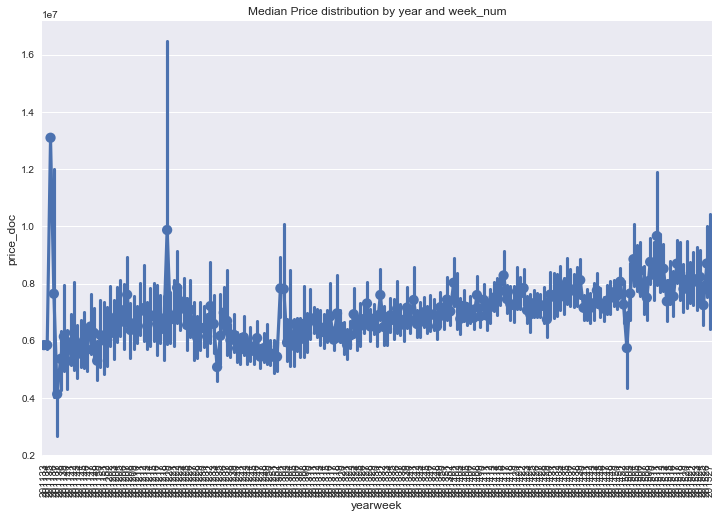

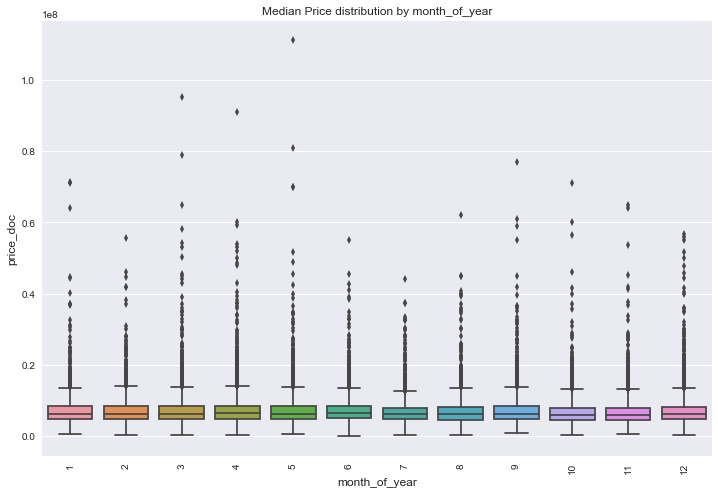

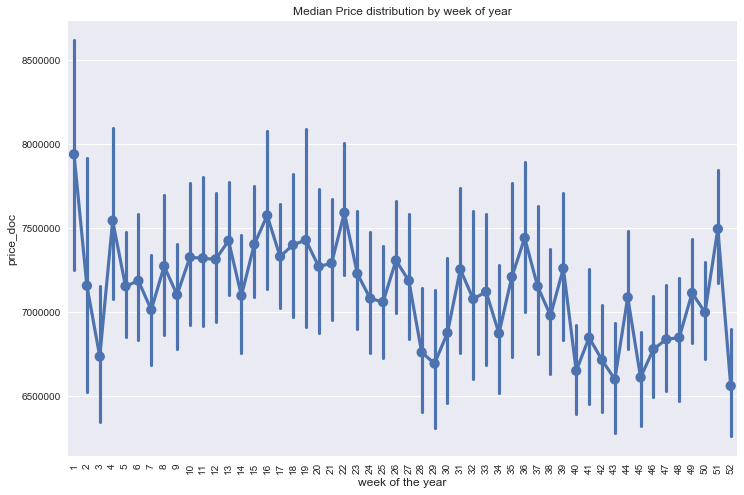

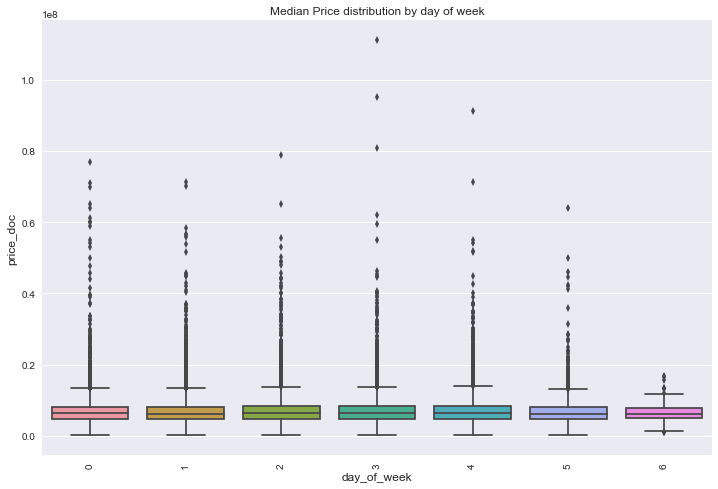

In [10]:
# viz above
plt.figure(figsize=(12,8))
sns.pointplot(x='yearweek', y='price_doc', data=train_df)
plt.ylabel('price_doc', fontsize=12)
plt.xlabel('yearweek', fontsize=12)
plt.title('Median Price distribution by year and week_num')
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(12,8))
sns.boxplot(x='month_of_year', y='price_doc', data=train_df)
plt.ylabel('price_doc', fontsize=12)
plt.xlabel('month_of_year', fontsize=12)
plt.title('Median Price distribution by month_of_year')
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(12,8))
sns.pointplot(x='week_of_year', y='price_doc', data=train_df)
plt.ylabel('price_doc', fontsize=12)
plt.xlabel('week of the year', fontsize=12)
plt.title('Median Price distribution by week of year')
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(12,8))
sns.boxplot(x='day_of_week', y='price_doc', data=train_df)
plt.ylabel('price_doc', fontsize=12)
plt.xlabel('day_of_week', fontsize=12)
plt.title('Median Price distribution by day of week')
plt.xticks(rotation='vertical')
plt.show()

Also from the [simple exploration notebook][1], we have seen that area of the property is the top variables. So creating some more features might be helpful.

Let us create some ratio variables around it.


  [1]: https://www.kaggle.com/sudalairajkumar/sberbank-russian-housing-market/simple-exploration-notebook-sberbank

In [137]:
# ratio of living area to full area #
train_df["ratio_life_sq_full_sq"] = train_df["life_sq"] / np.maximum(train_df["full_sq"].astype("float"),1)
test_df["ratio_life_sq_full_sq"] = test_df["life_sq"] / np.maximum(test_df["full_sq"].astype("float"),1)
train_df["ratio_life_sq_full_sq"].ix[train_df["ratio_life_sq_full_sq"]<0] = 0
train_df["ratio_life_sq_full_sq"].ix[train_df["ratio_life_sq_full_sq"]>1] = 1
test_df["ratio_life_sq_full_sq"].ix[test_df["ratio_life_sq_full_sq"]<0] = 0
test_df["ratio_life_sq_full_sq"].ix[test_df["ratio_life_sq_full_sq"]>1] = 1

# ratio of kitchen area to living area #
train_df["ratio_kitch_sq_life_sq"] = train_df["kitch_sq"] / np.maximum(train_df["life_sq"].astype("float"),1)
test_df["ratio_kitch_sq_life_sq"] = test_df["kitch_sq"] / np.maximum(test_df["life_sq"].astype("float"),1)
train_df["ratio_kitch_sq_life_sq"].ix[train_df["ratio_kitch_sq_life_sq"]<0] = 0
train_df["ratio_kitch_sq_life_sq"].ix[train_df["ratio_kitch_sq_life_sq"]>1] = 1
test_df["ratio_kitch_sq_life_sq"].ix[test_df["ratio_kitch_sq_life_sq"]<0] = 0
test_df["ratio_kitch_sq_life_sq"].ix[test_df["ratio_kitch_sq_life_sq"]>1] = 1

# ratio of kitchen area to full area #
train_df["ratio_kitch_sq_full_sq"] = train_df["kitch_sq"] / np.maximum(train_df["full_sq"].astype("float"),1)
test_df["ratio_kitch_sq_full_sq"] = test_df["kitch_sq"] / np.maximum(test_df["full_sq"].astype("float"),1)
train_df["ratio_kitch_sq_full_sq"].ix[train_df["ratio_kitch_sq_full_sq"]<0] = 0
train_df["ratio_kitch_sq_full_sq"].ix[train_df["ratio_kitch_sq_full_sq"]>1] = 1
test_df["ratio_kitch_sq_full_sq"].ix[test_df["ratio_kitch_sq_full_sq"]<0] = 0
test_df["ratio_kitch_sq_full_sq"].ix[test_df["ratio_kitch_sq_full_sq"]>1] = 1

d:\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: invalid value encountered in maximum
d:\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: invalid value encountered in maximum


In [ ]:
# viz above
plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.ratio_life_sq_full_sq.values, y=np.log1p(train_df.price_doc.values), size=10)
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Ratio of living area to full area', fontsize=12)
plt.title("Joint plot on log of living price to ratio_life_sq_full_sq")
plt.show()

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.ratio_life_sq_full_sq.values, y=np.log1p(train_df.price_doc.values), 
              kind='kde',size=10)
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Ratio of kitchen area to living area', fontsize=12)
plt.title("Joint plot on log of living price to ratio_kitch_sq_life_sq")
plt.show()

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.ratio_life_sq_full_sq.values, y=np.log1p(train_df.price_doc.values), 
              kind='kde',size=10)
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Ratio of kitchen area to full area', fontsize=12)
plt.title("Joint plot on log of living price to ratio_kitch_sq_full_sq")
plt.show()

Also the next important variables from EDA are floor and max_floor. So let us create two variables

 1. Floor number of the house to the total number of floors
 2. Number of floor from the top

In [146]:
# floor of the house to the total number of floors in the house #
train_df["ratio_floor_max_floor"] = train_df["floor"] / train_df["max_floor"].astype("float")
test_df["ratio_floor_max_floor"] = test_df["floor"] / test_df["max_floor"].astype("float")

# num of floor from top #
train_df["floor_from_top"] = train_df["max_floor"] - train_df["floor"]
test_df["floor_from_top"] = test_df["max_floor"] - test_df["floor"]

One more variable from floor area could be the difference between full area and living area.

In [ ]:
train_df["extra_sq"] = train_df["full_sq"] - train_df["life_sq"]
test_df["extra_sq"] = test_df["full_sq"] - test_df["life_sq"]

Age of building might have an impact in the rental price and so we can add that one as well.

In [ ]:
train_df["age_of_building"] = train_df["build_year"] - train_df["timestamp"].dt.year
test_df["age_of_building"] = test_df["build_year"] - test_df["timestamp"].dt.year

Price of the house could also be affected by the availability of other houses at the same time period. So creating a count variable on the number of houses at the given time period might help.

In [ ]:
def add_count(df, group_col):
    grouped_df = df.groupby(group_col)["id"].aggregate("count").reset_index()
    grouped_df.columns = [group_col, "count_"+group_col]
    df = pd.merge(df, grouped_df, on=group_col, how="left")
    return df

train_df = add_count(train_df, "yearmonth")
test_df = add_count(test_df, "yearmonth")

train_df = add_count(train_df, "yearweek")
test_df = add_count(test_df, "yearweek")

Since schools generally play an important role in house hunting, let us create some variables around school.

In [149]:
train_df["ratio_preschool"] = train_df["children_preschool"] / train_df["preschool_quota"].astype("float")
test_df["ratio_preschool"] = test_df["children_preschool"] / test_df["preschool_quota"].astype("float")

train_df["ratio_school"] = train_df["children_school"] / train_df["school_quota"].astype("float")
test_df["ratio_school"] = test_df["children_school"] / test_df["school_quota"].astype("float")

## drop

In [45]:
### We could potentially add more variables like this. But for now let us start with model building using these additional variables. Let us drop the variables which are not needed in model building.
train_X = train_df.drop(["id", "timestamp", "price_doc"], axis=1)
test_X = test_df.drop(["id", "timestamp"] , axis=1)
# Since our metric is "RMSLE", let us use log of the target variable for model building rather than using the actual target variable.
# train_y = np.log1p(train_df.price_doc.values)
train_y =(train_df.price_doc.values)

# CV
**Validation Methodology:**

But before building our models, let us do some local validation by splitting the train dataset.

In this competition, the train and test set are from different time periods and so let us use the last 1 year as validation set for building our models and rest as model development set.

In [46]:
val_time = 201407
#dev_indices = np.where(train_X["yearmonth"]<val_time)
#val_indices = np.where(train_X["yearmonth"]>=val_time)

dev_indices = np.where((train_df["timestamp"].dt.year<2014).values | ((train_df["timestamp"].dt.year == 2014).values & (train_df["timestamp"].dt.month < 7).values))
val_indices = np.where((train_df["timestamp"].dt.year>2014).values | ((train_df["timestamp"].dt.year == 2014).values & (train_df["timestamp"].dt.month >= 7).values))

In [47]:
dev_X = train_X.ix[dev_indices]
val_X = train_X.ix[val_indices]
dev_y = train_y[dev_indices]
val_y = train_y[val_indices]
print(dev_X.shape, val_X.shape)

((20483, 295), (9988, 295))


In [48]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
}

In [49]:
xgtrain = xgb.DMatrix(dev_X, dev_y, feature_names=dev_X.columns)
xgtest = xgb.DMatrix(val_X, val_y, feature_names=val_X.columns)
watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
num_rounds = 1000 # Increase the number of rounds while running in local
model = xgb.train(xgb_params, xgtrain, num_rounds, watchlist, early_stopping_rounds=20, verbose_eval=20)
# feval=lambda a,b: ('myrmse',rmse(a,b.get_label()))

[0]	train-rmse:7.84908e+06	test-rmse:8.99504e+06
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 20 rounds.
[20]	train-rmse:3.87682e+06	test-rmse:4.80027e+06
[40]	train-rmse:2.72392e+06	test-rmse:3.47801e+06
[60]	train-rmse:2.40758e+06	test-rmse:3.08318e+06
[80]	train-rmse:2.27091e+06	test-rmse:2.94306e+06
[100]	train-rmse:2.19472e+06	test-rmse:2.87043e+06
[120]	train-rmse:2.13342e+06	test-rmse:2.83394e+06
[140]	train-rmse:2.0866e+06	test-rmse:2.80011e+06
[160]	train-rmse:2.04652e+06	test-rmse:2.77718e+06
[180]	train-rmse:2.01475e+06	test-rmse:2.76559e+06
[200]	train-rmse:1.98004e+06	test-rmse:2.75233e+06
[220]	train-rmse:1.95144e+06	test-rmse:2.74277e+06
[240]	train-rmse:1.92283e+06	test-rmse:2.73573e+06
[260]	train-rmse:1.89125e+06	test-rmse:2.72518e+06
[280]	train-rmse:1.86684e+06	test-rmse:2.71942e+06
[300]	train-rmse:1.84437e+06	test-rmse:2.70706e+06
[320]	train-rmse:1.82066e+06	test-rmse:2.70329e+

In [50]:
dtest = xgb.DMatrix(pd.DataFrame(val_X))
y_predict = model.predict(dtest)
print rmse(y_predict,val_y)
print logrmse(y_predict,val_y)

2697558.1945
0.422684521455


In [51]:
dtest = xgb.DMatrix(pd.DataFrame(dev_X))
y_predict = model.predict(dtest)
print rmse(y_predict,dev_y)
print logrmse(y_predict,dev_y)

1751435.4331
0.438434588714


In [16]:
temp = dev_y > 0

## direct CV

In [354]:
dtrain = xgb.DMatrix(train_X, train_y)

#### cv after log

In [283]:
# wrong sample
cv_output = xgb.cv(xgb_params, dtrain, 1000, nfold=5,
       seed = 0, early_stopping_rounds=20, verbose_eval=20,
       show_stdv=False)

[0]	train-rmse:14.3667	test-rmse:14.3667
[20]	train-rmse:5.17349	test-rmse:5.17359
[40]	train-rmse:1.90789	test-rmse:1.91052
[60]	train-rmse:0.806748	test-rmse:0.816336
[80]	train-rmse:0.507084	test-rmse:0.526466
[100]	train-rmse:0.447713	test-rmse:0.474291
[120]	train-rmse:0.433706	test-rmse:0.465491
[140]	train-rmse:0.427	test-rmse:0.463424
[160]	train-rmse:0.42197	test-rmse:0.462722
[180]	train-rmse:0.417581	test-rmse:0.462275
[200]	train-rmse:0.413204	test-rmse:0.461991
[220]	train-rmse:0.409114	test-rmse:0.461691


#### cv without log

In [37]:
# macro timestamp fix
cv_output = xgb.cv(xgb_params, dtrain, 1000, nfold=5,
       seed = 0, early_stopping_rounds=20, verbose_eval=50,feval=xgblogrmse,
       show_stdv=False)

[0]	train-logrmse:2.95226	train-rmse:8.20718e+06	test-logrmse:2.95454	test-rmse:8.21206e+06
[50]	train-logrmse:0.464561	train-rmse:2.54129e+06	test-logrmse:0.474166	test-rmse:2.88807e+06
[100]	train-logrmse:0.460493	train-rmse:2.20715e+06	test-logrmse:0.474744	test-rmse:2.70359e+06
[150]	train-logrmse:0.45279	train-rmse:2.07908e+06	test-logrmse:0.472054	test-rmse:2.66119e+06
[200]	train-logrmse:0.445596	train-rmse:1.98742e+06	test-logrmse:0.470056	test-rmse:2.63957e+06
[250]	train-logrmse:0.439135	train-rmse:1.91377e+06	test-logrmse:0.46864	test-rmse:2.62645e+06
[300]	train-logrmse:0.433103	train-rmse:1.85385e+06	test-logrmse:0.467786	test-rmse:2.6163e+06
[350]	train-logrmse:0.427187	train-rmse:1.79677e+06	test-logrmse:0.467101	test-rmse:2.60882e+06
[400]	train-logrmse:0.421469	train-rmse:1.74633e+06	test-logrmse:0.466734	test-rmse:2.60535e+06
[450]	train-logrmse:0.415883	train-rmse:1.70027e+06	test-logrmse:0.46653	test-rmse:2.60418e+06
[500]	train-logrmse:0.410648	train-rmse:1.65904e+

In [355]:
# macro downsample timestamp
cv_output = xgb.cv(xgb_params, dtrain, 1000, nfold=5,
       seed = 0, early_stopping_rounds=20, verbose_eval=50,feval=xgblogrmse,
       show_stdv=False)

[0]	train-logrmse:2.95609	train-rmse:8.41275e+06	test-logrmse:2.95691	test-rmse:8.41873e+06
[50]	train-logrmse:0.325862	train-rmse:2.26813e+06	test-logrmse:0.335466	test-rmse:2.68576e+06
[100]	train-logrmse:0.316615	train-rmse:1.8866e+06	test-logrmse:0.330591	test-rmse:2.47801e+06
[150]	train-logrmse:0.308977	train-rmse:1.7519e+06	test-logrmse:0.327137	test-rmse:2.42226e+06
[200]	train-logrmse:0.302593	train-rmse:1.66147e+06	test-logrmse:0.32495	test-rmse:2.39706e+06
[250]	train-logrmse:0.297311	train-rmse:1.58877e+06	test-logrmse:0.323832	test-rmse:2.38341e+06
[300]	train-logrmse:0.292181	train-rmse:1.52651e+06	test-logrmse:0.322872	test-rmse:2.37389e+06
[350]	train-logrmse:0.28744	train-rmse:1.47359e+06	test-logrmse:0.322164	test-rmse:2.36608e+06
[400]	train-logrmse:0.282888	train-rmse:1.42597e+06	test-logrmse:0.321744	test-rmse:2.36161e+06
[450]	train-logrmse:0.278534	train-rmse:1.38225e+06	test-logrmse:0.321353	test-rmse:2.35665e+06
[500]	train-logrmse:0.27437	train-rmse:1.34326e+0

In [341]:
# macro downsample
cv_output = xgb.cv(xgb_params, dtrain, 1000, nfold=5,
       seed = 0, early_stopping_rounds=20, verbose_eval=50,feval=xgblogrmse,
       show_stdv=False)

[0]	train-logrmse:2.95588	train-rmse:8.41323e+06	test-logrmse:2.95707	test-rmse:8.41866e+06
[50]	train-logrmse:0.325787	train-rmse:2.27829e+06	test-logrmse:0.336052	test-rmse:2.69718e+06
[100]	train-logrmse:0.316698	train-rmse:1.89031e+06	test-logrmse:0.331184	test-rmse:2.49191e+06
[150]	train-logrmse:0.309296	train-rmse:1.75523e+06	test-logrmse:0.327924	test-rmse:2.44224e+06
[200]	train-logrmse:0.302602	train-rmse:1.65932e+06	test-logrmse:0.325646	test-rmse:2.41349e+06
[250]	train-logrmse:0.297044	train-rmse:1.58587e+06	test-logrmse:0.324352	test-rmse:2.40049e+06
[300]	train-logrmse:0.291731	train-rmse:1.52198e+06	test-logrmse:0.323491	test-rmse:2.38841e+06
[350]	train-logrmse:0.287088	train-rmse:1.47172e+06	test-logrmse:0.323035	test-rmse:2.38304e+06
[400]	train-logrmse:0.282705	train-rmse:1.42441e+06	test-logrmse:0.322556	test-rmse:2.37791e+06
[450]	train-logrmse:0.278312	train-rmse:1.38095e+06	test-logrmse:0.322128	test-rmse:2.37318e+06
[500]	train-logrmse:0.274109	train-rmse:1.341

In [324]:
# macro timestamp
cv_output = xgb.cv(xgb_params, dtrain, 1000, nfold=5,
       seed = 0, early_stopping_rounds=20, verbose_eval=50,feval=xgblogrmse,
       show_stdv=False)

[0]	train-logrmse:2.95259	train-rmse:8.20721e+06	test-logrmse:2.95522	test-rmse:8.21234e+06
[50]	train-logrmse:0.464394	train-rmse:2.53255e+06	test-logrmse:0.474136	test-rmse:2.88248e+06
[100]	train-logrmse:0.46012	train-rmse:2.20047e+06	test-logrmse:0.474671	test-rmse:2.69766e+06
[150]	train-logrmse:0.452452	train-rmse:2.07756e+06	test-logrmse:0.47203	test-rmse:2.64923e+06
[200]	train-logrmse:0.445368	train-rmse:1.98736e+06	test-logrmse:0.47024	test-rmse:2.62823e+06
[250]	train-logrmse:0.439031	train-rmse:1.9153e+06	test-logrmse:0.469241	test-rmse:2.61734e+06
[300]	train-logrmse:0.43274	train-rmse:1.852e+06	test-logrmse:0.468455	test-rmse:2.61094e+06
[350]	train-logrmse:0.426969	train-rmse:1.79705e+06	test-logrmse:0.467837	test-rmse:2.60484e+06
[400]	train-logrmse:0.421463	train-rmse:1.74748e+06	test-logrmse:0.467495	test-rmse:2.60406e+06


In [261]:
# macro
cv_output = xgb.cv(xgb_params, dtrain, 1000, nfold=5,
       seed = 0, early_stopping_rounds=20, verbose_eval=20,feval=xgblogrmse,
       show_stdv=False)

[0]	train-logrmse:2.95226	train-rmse:8.20718e+06	test-logrmse:2.95454	test-rmse:8.21206e+06
[20]	train-logrmse:0.573094	train-rmse:3.97013e+06	test-logrmse:0.578197	test-rmse:4.09554e+06
[40]	train-logrmse:0.468981	train-rmse:2.76208e+06	test-logrmse:0.477491	test-rmse:3.04751e+06
[60]	train-logrmse:0.463858	train-rmse:2.4209e+06	test-logrmse:0.474402	test-rmse:2.80824e+06
[80]	train-logrmse:0.462677	train-rmse:2.28646e+06	test-logrmse:0.475091	test-rmse:2.7375e+06
[100]	train-logrmse:0.460493	train-rmse:2.20715e+06	test-logrmse:0.474744	test-rmse:2.70359e+06
[120]	train-logrmse:0.457556	train-rmse:2.14953e+06	test-logrmse:0.473692	test-rmse:2.68487e+06
[140]	train-logrmse:0.45427	train-rmse:2.10133e+06	test-logrmse:0.4726	test-rmse:2.6672e+06
[160]	train-logrmse:0.451218	train-rmse:2.05851e+06	test-logrmse:0.471611	test-rmse:2.65689e+06
[180]	train-logrmse:0.448261	train-rmse:2.01969e+06	test-logrmse:0.470683	test-rmse:2.64626e+06
[200]	train-logrmse:0.445596	train-rmse:1.98742e+06	te

In [236]:
# normal
cv_output = xgb.cv(xgb_params, dtrain, 1000, nfold=5,
       seed = 0, early_stopping_rounds=20, verbose_eval=20,feval=xgblogrmse,
       show_stdv=False)

[0]	train-logrmse:2.94499	train-rmse:8.22045e+06	test-logrmse:2.94555	test-rmse:8.22318e+06
[20]	train-logrmse:0.573758	train-rmse:3.96821e+06	test-logrmse:0.578467	test-rmse:4.08667e+06
[40]	train-logrmse:0.469632	train-rmse:2.76346e+06	test-logrmse:0.47726	test-rmse:3.02471e+06
[60]	train-logrmse:0.465	train-rmse:2.42926e+06	test-logrmse:0.474832	test-rmse:2.78547e+06
[80]	train-logrmse:0.464304	train-rmse:2.29869e+06	test-logrmse:0.475891	test-rmse:2.71693e+06
[100]	train-logrmse:0.462663	train-rmse:2.22622e+06	test-logrmse:0.475735	test-rmse:2.68301e+06
[120]	train-logrmse:0.46022	train-rmse:2.17492e+06	test-logrmse:0.474747	test-rmse:2.66177e+06
[140]	train-logrmse:0.45782	train-rmse:2.13267e+06	test-logrmse:0.47402	test-rmse:2.64742e+06
[160]	train-logrmse:0.455412	train-rmse:2.09733e+06	test-logrmse:0.473233	test-rmse:2.63836e+06
[180]	train-logrmse:0.452808	train-rmse:2.06289e+06	test-logrmse:0.4725	test-rmse:2.62832e+06
[200]	train-logrmse:0.450576	train-rmse:2.03187e+06	test-

Beware that adding irrelevant variables will degrade the performance of the models. So use cross-validation and pick the best ones.! 

In [ ]:
# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

# xgb train and predict

In [52]:
dtrain = xgb.DMatrix(train_X, train_y)
num_boost_rounds = 380
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

In [ ]:
model.save_model("xgb.model")

In [53]:
dtest = xgb.DMatrix(pd.DataFrame(test_X))
y_predict = model.predict(dtest)
#y_predict = np.exp(y_predict)
y_predict = (y_predict)

In [158]:
y_predict = y_predict * 0.96

In [54]:
output = pd.DataFrame({'id': test_df.id, 'price_doc': y_predict})
output.to_csv('xgbSub_.csv', index=False)